In [1]:
from abc import ABCMeta, abstractmethod, abstractproperty
import os
import sqlite3
import pandas as pd

import requests
import json
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time
from dataclasses import dataclass
from urllib.parse import urlparse, parse_qs, urlencode

from gensim.models import Word2Vec
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import FastText
from transformers import BertModel, BertTokenizer
import torch
import spacy
import re

import ast

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import Counter
import joblib

from pandarallel import pandarallel

E:\python\conda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Описание проекта

Проект Близкие вакансии. По опыту резюме необходимо получить 10 наиболее релевантных вакансий.

1) Получение вакансий из открытых источников. По api hhru получено 150 тысяч описаний вакансий. Так же получена тестовая выборка для определения качества моделей. 

2) Предобработка и векторизация описаний вакансий и опыта резюме. Предобработка с помощью spacy. Удалил стоп слова, наиболее частые слова, сделал лемматизацию, оставил только буквы. 

3) Векторизация c помощью моделей FastText, TFIDF, Wor2Vec. Bert не смог запустить, тк вакансий было много. 

4) На основании косинусного сходства получаем вектора близких вакансий


*Что улучшить??? - использовать bert, ускорить вычисление косинусного сходства.* 

*Трудности!!!! Очень много съедается памяти, долго идут вычисления - чатично решено за счет параллельных вычислений*

# Скачивание данных с api hh.ru для обучающей выборки
Ограничением api hh.ru является то, что за один раз можно скачать только 2000 вакансий.
Для получения большего количества вакансий были сформированы url с фильтрами так, что количесво записей получалось меньше 2000. Разбивка в основном была по регионам, профессиям, станциям метро. 
Скачать удалось не все, тк api выкидывает ошибки, если не использовать паузы. Для скачивания всей возможной выборки возможно потребуется использование нескольких экземпляров парсеров с разных ip адресов.
Удалось скачать около 150 тысяч описаний вакансий. Резюме с api hh.ru получить не удалось. 

In [ ]:
@dataclass
class ClusterId:
    region: str = "area"
    metro: str = "metro"
    professional_role: str = "professional_role"
    salary: str = "salary"
    experience: str = "experience"

class HhParser:

    def __init__(self, cluster_id: ClusterId):
        self._base_url = 'https://api.hh.ru/vacancies?clusters=true'
        self.urls = []
        self._cluster_id = cluster_id

    def get_vacancy_cluster_urls(self):
        json = self.get_json(self._base_url)
        items = self.get_region_clusters(json)

        self.urls.extend((i.get('url'), int(i.get('count'))) for i in self.filter_less_than_2000(items))

        more_than_2000 = [i for i in self.filter_more_than_2000(items) if str(i.get('name')) != 'Россия']

        extend_region_items = self.get_extend_region_clusters(more_than_2000)

        self.urls.extend((i.get('url'), int(i.get('count'))) for i in self.filter_less_than_2000(extend_region_items))
        more_than_2000 = [i for i in self.filter_more_than_2000(extend_region_items)]
        more_than_2000.extend(i for i in extend_region_items if int(i.get('count')) == 0)

        role_items = self.get_items_by_prof_role(more_than_2000)
        self.urls.extend((i.get('url'), int(i.get('count'))) for i in self.filter_less_than_2000(role_items))
        more_than_2000 = [i for i in self.filter_more_than_2000(role_items)]

        experience_items = self.get_items_by_prof_role(more_than_2000)
        self.urls.extend((i.get('url'), int(i.get('count'))) for i in self.filter_less_than_2000(experience_items))
        more_than_2000 = [i for i in self.filter_more_than_2000(experience_items)]

        self.urls = list(set(self.urls))

        print(f'The total number of {len(self.urls)} URLs collected')


    def get_extend_region_clusters(self, region_items):
        items = []

        for item in tqdm(region_items, 'Get extend region clusters'):
            url = item.get('url')

            if url is None:
                continue

            time.sleep(2)
            json = self.get_json(url)

            metro_items = self.get_metro_clusters(json)
            metro_items = self.filter_metro_station_items(metro_items)

            if len(metro_items) > 0:
                items.extend(metro_items)
            else:
                extend_region_items = self.get_region_clusters(json)

                if len(extend_region_items) > 1:
                    items.extend(extend_region_items[:-1])
                else:
                    items.extend(extend_region_items)
        return items

    def get_items_by_prof_role(self, extend_items):
        items = []

        for item in tqdm(extend_items, 'Get items by prof role'):
            url = item.get('url')

            if url is None:
                continue

            time.sleep(1)

            json = self.get_json(url)
            prof_role_items = self.get_role_clusters(json)

            items.extend(prof_role_items)

        return items

    def get_items_by_experience(self, role_items):
        items = []

        for item in tqdm(role_items, 'Get items by experience'):
            url = item.get('url')

            if url is None:
                continue

            time.sleep(0.5)

            json = self.get_json(url)
            experience_items = self.get_experience_clusters(json)

            items.extend(experience_items)

        return items

    def filter_less_than_2000(self, items):
        return [i for i in items if int(i.get('count')) <= 2000 and int(i.get('count')) != 0]

    def filter_more_than_2000(self, items):
        return [i for i in items if int(i.get('count')) > 2000]

    def get_cluster_items(self, json, cluster_id):
        clusters = json.get('clusters')

        if not clusters:
            print('key error: clusters')
            return []

        cluster = self.get_cluster_by_id(clusters, cluster_id)

        if not cluster:
            return []

        items = cluster.get('items')

        if not items:
            print('key error: items')
            return []

        return items

    def get_cluster_by_id(self, clusters, cluster_id):
        for cluster in clusters:
            _id = str(cluster.get('id'))

            if _id == cluster_id:
                return cluster

        return []

    def get_region_clusters(self, json_data):
        if json_data:
            items = self.get_cluster_items(json_data, self._cluster_id.region)
            return  items
        else:
            print('get_region_clusters: Not found json in get response!')
            return []

    def get_metro_clusters(self, json_data):
        if json_data:
            items = self.get_cluster_items(json_data, self._cluster_id.metro)
            return items
        else:
            print('get_metro_clusters: Not found json in get response!')
            return []

    def get_role_clusters(self, json_data):
        if json_data:
            items = self.get_cluster_items(json_data, self._cluster_id.professional_role)
            return items
        else:
            print('get_role_clusters: Not found json in get response!')
            return []

    def get_experience_clusters(self, json_data):
        if json_data:
            items = self.get_cluster_items(json_data, self._cluster_id.experience)
            return items
        else:
            print('get_role_clusters: Not found json in get response!')
            return []

    def filter_metro_station_items(self, metro_items):
        return [i for i in metro_items if str(i.get('type')) == 'metro_station']

    def get_json(self, url):
        response = requests.get(url, verify=False)

        if response.status_code == 200:
            json = response.json()

            if not json:
                return None;

            return json
        else:
            print(f"Failed to get json data by url {url}, status {response.status_code}, text - {response.text}")
            return None


In [ ]:
cluster_id = ClusterId()

parser = HhParser(cluster_id)
parser.get_vacancy_cluster_urls()

sorted_list = sorted(parser.urls, key=lambda x: x[1])

In [ ]:
# объединяем url так, чтобы количество записей по ним было максимальным, но не больше 2000
def parse_and_modify_urls(url_tuples):
    url_params_map = {}

    # Группируем URL по набору имен параметров
    for url, count in url_tuples:
        parsed_url = urlparse(url)
        query_params = parse_qs(parsed_url.query)
        query_params.pop('clusters', None)  # Убираем параметр 'clusters'
        query_param_names = sorted(query_params.keys())  # Получаем наименования параметров и сортируем их
        query_param_key = ','.join(query_param_names)

        if query_param_key not in url_params_map:
            url_params_map[query_param_key] = []

        url_params_map[query_param_key].append((url, count))

    modified_urls = []

    # Формируем новые URL с суммой количества, не превышающей 2000
    for query_param_key, url_count_pairs in url_params_map.items():
        total_count = 0
        combined_params = []

        # Набираем параметры для нового URL
        for url, count in url_count_pairs:

            if total_count + count <= 2000:
                total_count += count
                parsed_url = urlparse(url)
                query_params = parse_qs(parsed_url.query)
                for param_name, param_values in query_params.items():
                    combined_params.append((param_name, param_values[0]))  # Добавляем все значения параметров
            else:

                # Убираем параметр 'clusters' из объединенных параметров, если он есть
                combined_params = [(param_name, param_value) for param_name, param_value in combined_params if param_name != 'clusters']

                # Преобразуем объединенные параметры в строку
                new_query = urlencode(combined_params, doseq=True)
                new_url = f"{parsed_url.scheme}://{parsed_url.netloc}{parsed_url.path}?{new_query}"
                modified_urls.append((new_url, total_count))  # Добавляем новый URL с суммарным количеством

                combined_params = []
                total_count = count

                parsed_url = urlparse(url)
                query_params = parse_qs(parsed_url.query)

                for param_name, param_values in query_params.items():
                    combined_params.append((param_name, param_values[0]))  # Добавляем все значения параметров

        # Убираем параметр 'clusters' из объединенных параметров, если он есть
        combined_params = [(param_name, param_value) for param_name, param_value in combined_params if param_name != 'clusters']

        # Преобразуем объединенные параметры в строку
        new_query = urlencode(combined_params, doseq=True)
        new_url = f"{parsed_url.scheme}://{parsed_url.netloc}{parsed_url.path}?{new_query}"
        modified_urls.append((new_url, total_count))  # Добавляем новый URL с суммарным количеством

    return modified_urls


modified_urls = parse_and_modify_urls(sorted_list)

In [3]:

class DataSourcePdAdapter():
    __metaclass__ = ABCMeta

    def __init__(self, directory_path, file_name):
        self._directory_path = directory_path
        self._file_name = file_name
        self._extension = ''        
        self._check_filename()

    def _get_full_path(self):
        path = os.path.join(self._directory_path, f'{self._file_name}.{self._extension}')
        return path

    def _check_directory_path(self):
        if self._directory_path == '':
            return 
        if not os.path.exists(self._directory_path):
            os.mkdir(self._directory_path)

        if not os.path.exists(self._directory_path):
            raise Exception(f'Ошибка при создании каталога {self._directory_path}')

    def _check_filename(self):
        if self._file_name == '':
            raise Exception(f'file_name не может быть пустой строкой!')

    @abstractmethod
    def write(self, df):
        pass

    @abstractmethod
    def _read(self):
        pass

class CsvPdAdapter(DataSourcePdAdapter):

    def __init__(self, directory_path, file_name, sep=','):
        super().__init__(directory_path, file_name)
        self._sep = sep
        self._extension = 'csv'

    def write(self, df):
        df.to_csv(self._get_full_path(), index=False, sep=self._sep)

    def read(self, n_rows=None, chunksize=None):
        path = self._get_full_path()
        print(path)
        return pd.read_csv(path, sep=self._sep, chunksize=chunksize, nrows=n_rows, engine='python')

class SqlLitePdAdapter(DataSourcePdAdapter):
    def __init__(self, directory_path, file_name, table_name):
        super().__init__(directory_path, file_name)
        self._table = table_name
        self._operation_type = 'append'
        self._extension = 'db'

        self._create_table()

    def _create_table(self):
        with sqlite3.connect(self._get_full_path()) as con:
            con.execute(f"""
                CREATE TABLE if not exists {self._table} (
                    id INTEGER PRIMARY KEY,
                    name VARCHAR(100),
                    description TEXT,
                    branded_description TEXT,
                    key_skills VARCHAR(200),
                    professional_roles VARCHAR(200)

                );
            """)

    def write(self, df):
        self._check_directory_path()
        with sqlite3.connect(self._get_full_path()) as con:
            df.to_sql(self._table, con, index=False, if_exists="replace")

    def write_row(self, vacancy):
        self._check_directory_path()
        
        with sqlite3.connect(self._get_full_path()) as connection:
            cursor = connection.cursor()

            try:
                  cursor.execute(
                      f"""
                      INSERT INTO {self._table}
                      (
                        id, name, description, branded_description, key_skills, professional_roles
                      )
                      VALUES (?, ?, ?, ?, ?, ?)
                      """, (vacancy.id, vacancy.name, vacancy.description, vacancy.branded_description,
                            vacancy.key_skills, vacancy.professional_roles)
                )
            except Exception as ex:
                print(f'vacancy - {str(vacancy)}')
                print(f'ошибка при записи в БД - {ex}')
                
                raise ex

    def read_all(self, chunksize=None):
        query = f'select * from {self._table}'
        with sqlite3.connect(self._get_full_path()) as con:   
            con.text_factory = str
            con.text_factory = lambda b: b.decode(errors='ignore')
            return pd.read_sql(query, con, chunksize=chunksize)

    def read(self, query_params_str='', target_columns=None):
        if target_columns:
            target_columns_srt = ', '.join(target_columns)
        else:
            target_columns_srt = '*'

        query = f'select {target_columns_srt} from {self._table} {query_params_str}'
        
        with sqlite3.connect(self._get_full_path()) as con:
            return pd.read_sql(query, con)


In [3]:
sqlite3_adapter = SqlLitePdAdapter('', 'vacancies', 'vacancies')

In [ ]:
@dataclass
class Vacancy:
    id: int
    name: str
    description: str
    branded_description: str
    key_skills: str
    professional_roles: str

In [ ]:
# Получение подробных данных по каждой вакансии, каждую запись сохраняем сразу в БД, ошибки игнорируем
def fetch_vacancies(url):
    per_page = 100
    extracted_vacancies = 0
    continues_vac = 0

    ids = []

    result_db = sqlite3_adapter.read(target_columns=['id'])   

    total_pages = 2000 // per_page + (1 if 2000 % per_page != 0 else 0)
    ids = []
    
    captcha_vacancies = []

    for page in range(0, 1):  # получить данные по всем страницам не реально под одним ip
        params = {'per_page': per_page, 'page': page}
        
        try:
            response = requests.get(url, params=params)
        except Exception as ex:
            print(f'ошибка при получении списка вакансий {ex}')
            continue

        if response.status_code == 200:
            time.sleep(0.2)
            vacancies = response.json()

            for item in tqdm(vacancies['items']):
                is_exists = result_db["id"].isin([int(item['id'])]).any()

                if is_exists or item['id'] in ids:
                    continues_vac += 1
                    continue

                time.sleep(0.3)

                try:
                    result = get_vacancy(item['id'])
                except Exception as ex:
                    print(f'ошибка при получении вакансии - {ex}')
                    continue

                if 'captcha_required' in str(result):
                    time.sleep(1)                    
                    captcha_vacancies.append(item['id'])
                    continue

                if 'errors' in str(result):
                    time.sleep(2)                    
                    captcha_vacancies.append(item['id'])
                    continue

                _id = int(result.get('id'))
                name = result.get('name')
                description = result.get('description')
                branded_description = result.get('branded_description')
                key_skills = ' '.join(i.get('name') for i in result.get('key_skills'))
                professional_roles = ' '.join(i.get('name') for i in result.get('professional_roles'))

                vacancy = Vacancy(_id, name, description, branded_description, key_skills, professional_roles)

                try:
                    sqlite3_adapter.write_row(vacancy)
                except Exception as e:
                    print(e)
                    continue

                ids.append(_id)
                extracted_vacancies += 1

        elif response.status_code == 400 :
            print("Reached the limit of 2000 items. Stopping further fetching.")

        else:
            print(response.text)
            print(f"Error fetching vacancies. Status code: {response.status_code}")

    print(f'вакансий получено - {extracted_vacancies}')
    print(f'вакансий пропущено - {continues_vac}')
    print(f'вакансий с ошибкой - {len(captcha_vacancies)}')
    
    return captcha_vacancies

def get_vacancy(id_vacancy):
    target_url = f'https://api.hh.ru/vacancies/{id_vacancy}'
    vacancy = requests.get(target_url).json()
    return vacancy

for ind in range(0, len(modified_urls) - 1):
    url = modified_urls[ind]   
    fetch_vacancies(url[0])

In [ ]:
full_df = pd.DataFrame()
chunk_size = 10000  

for chunk in sqlite3_adapter.read_all(chunksize=chunk_size):
    full_df = pd.concat([full_df, chunk], ignore_index=True)


In [ ]:
full_df.shape[0]

In [ ]:
# объединяем данные по вакансии в одно описание, нас интересуют название вакансии, ключевые навыки и описание вакансии.
full_df['description_all'] = full_df['name'] + ' ' + full_df['description'] + ' ' + full_df['key_skills']
sqlite3_adapter.write(full_df)

## Получение тестовой выборки

Тестовая выборка на основе баз данных с сайта https://data.rcsi.science/data-catalog/datasets/186/#dataset-codebook 
Были получены описания вакансий и резюме, а так же отклики кандидатов на вакансии. По откликам столкнул вакансии и резюме.
Для уменьшения размера выборки выбрал резюме, по которым было отправлено более 3-х откликов. 
По полученным id резюме выбрал описания опыта резюме, а так же id вакансий. 
Из полученной выборки выбрал 1 резюме и по названию должности искал 10 вакансий для резюме.
Результат сохранил в csv resultResponsesTest. 
Так же в csv файле добавлены вручную id вакансий и некоторые тест-кейсы для получения более разнообразной выборки.
Итоговая тестовая выборка собрана в файле resultResponsesTest

В итоге собрано 325 резюме и покаждому по наименованию должности подобрано 10 описаний вакансий


In [ ]:
trud_vsem_path = r'D:\vacancies_project'

trud_response_csv_adapter = CsvPdAdapter(trud_vsem_path, 'responses', sep=';')
trud_vacancies_csv_adapter = CsvPdAdapter(trud_vsem_path, 'vacancies', sep=';')
trud_resume_csv_adapter = CsvPdAdapter(trud_vsem_path, 'workexp', sep=';')

In [ ]:
responses_df = pd.DataFrame()
chunk_size = 10000  

for chunk in trud_response_csv_adapter.read(chunksize=chunk_size):
    responses_df = pd.concat([responses_df, chunk], ignore_index=True)

In [ ]:
# получение выборки с откликами
responses_df = responses_df[responses_df['response_type'] == 'Принятие']

response_unique = responses_df.drop_duplicates(subset=['id_cv', 'id_vacancy'])

group_count_df = response_unique\
                .groupby('id_cv', as_index=False)\
                .count()\
                .sort_values(by='activity_flag_candidate', ascending=False)

filtered_response_df = group_count_df.query('activity_flag_candidate >= 3')

In [ ]:
filtered_response_df.head(2)

In [ ]:
id_cv_response = set(filtered_response_df['id_cv'])

result_response_df = response_unique[response_unique['id_cv'].isin(id_cv_response)]
result_response_df = result_response_df[['id_cv', 'id_vacancy']]
result_response_df 

In [ ]:
# получаем id вакансий, которые будем читать из файла, тк файл огромный, все вакансии не нужны
filtered_vacancies_response_df = responses_df[(responses_df['id_cv'].isin(id_cv_response)) & (responses_df['response_type'] == 'Принятие')]
id_vacancies_response = set(filtered_vacancies_response_df['id_vacancy'])

In [ ]:
# получаем резюме из csv 
result_resume_chunk_df = pd.DataFrame()
chunk_size = 10000  

for chunk in tqdm(trud_resume_csv_adapter.read(chunksize=chunk_size)):
    filtered_chunk = chunk[chunk['id_cv'].isin(id_cv_response)]    
    result_resume_chunk_df = pd.concat([result_resume_chunk_df, filtered_chunk], ignore_index=True)    

In [ ]:
# получаем вакансии из csv 
result_vacancies_chunk_df = pd.DataFrame()
chunk_size = 30000  

for chunk in tqdm(trud_vacancies_csv_adapter.read(chunksize=chunk_size)):
    filtered_chunk = chunk[chunk['identifier'].isin(id_vacancies_response)]
    result_vacancies_chunk_df = pd.concat([result_vacancies_chunk_df, filtered_chunk], ignore_index=True)

In [ ]:
# формируем датафрейм с описаниями вакансий
result_vacancies_df = result_vacancies_chunk_df[['identifier', 'responsibilities', 'title', 'requirements_qualifications', 'employment_type', 'education_requirements_speciality', 'education_requirements_education_type']]
result_vacancies_df.fillna('', inplace=True)
result_vacancies_df['education_requirements_education_type'] = result_vacancies_df['education_requirements_education_type'].apply(lambda x: f'образование {x}' if x != '' else x)

result_vacancies_df['vacancy_description'] = result_vacancies_df.apply(
    lambda row: f"{row['title']}\
    {row['responsibilities']}\
    {row['education_requirements_education_type']}\
    {row['education_requirements_speciality']}\
    {row['employment_type']}", 
    axis=1
)

In [ ]:
professions = set(result_resume_chunk_df['job_title'])
prof_vacancies = result_vacancies_df[result_vacancies_df['title'].isin(professions)].drop_duplicates('vacancy_description')

In [ ]:
# оставляем только 10 вакансий на каждое название профессии
filtered_prof_df = prof_vacancies.groupby('title').head(10)
filtered_prof_df = filtered_prof_df.groupby('title').filter(lambda x: len(x) == 10)

In [ ]:
# получение датафрейма с описаниями резюме
result_resume_chunk_df.fillna('', inplace=True)
result_resume_df_unique = result_resume_chunk_df.drop_duplicates()

result_resume_df_unique['resume_description'] = result_resume_df_unique.apply(
    lambda row: f"{row['job_title']}\
    {row['date_from']}\
    {row['date_to']}\
    {row['company_name']}\
    {row['demands']}", 
    axis=1
)

result_resume_df_unique = result_resume_df_unique[['id_cv', 'resume_description']]
result_resume_df_unique = result_resume_df_unique.drop_duplicates()
result_resume_df_unique.head()

In [ ]:
# формирование тестовой выборки 
n = 0
prof_df = pd.DataFrame()
for title in tqdm(set(filtered_prof_df.title)):   
    
    for i in list(filtered_prof_df[filtered_prof_df.title == title].vacancy_description):
        row = {}    
        row['id_cv'] = n
        row['resume_description'] = result_resume_df_unique[result_resume_df_unique['resume_description'].str.startswith(title)].resume_description.iloc[0]
        row['id_vacancy'] = '' # добавил вручную в файле
        row['vacancy_description'] = i
        row_df = pd.DataFrame([row])
        
        prof_df = pd.concat([prof_df, row_df], ignore_index=True)
    n += 1

In [ ]:
%%time
prof_df['resume_description_proc'] = prof_df['resume_description'].apply(processor.preprocess_text)
prof_df['vacancy_description_proc'] = prof_df['vacancy_description'].apply(processor.preprocess_text)

In [ ]:
trud_result_csv_adapter = CsvPdAdapter('', 'resultResponsesTest', sep=';')
trud_result_csv_adapter.write(prof_df)

In [ ]:
test_vacancies_df = trud_result_csv_adapter.read()

# Получение и обработка обучающей выборки
Обучающая выборка состоит из ~ 150 000 записей описаний вакансий, используются колокни - Наименование вакансии, ключевые навыки, описание вакансий

In [4]:
sqlite3_adapter = SqlLitePdAdapter('', 'vacancies', 'vacancies')

train_vacancies_df = pd.DataFrame()
chunk_size = 10000  

for chunk in sqlite3_adapter.read_all(chunksize=chunk_size):
    train_vacancies_df = pd.concat([train_vacancies_df, chunk], ignore_index=True)

In [6]:
train_vacancies_df.head()

,id,name,professional_role_id,description_all,vacancy_description_proc,vacancy_description_toc,fasttext_v,word2vec_v
0,18330133,Агент по недвижимости (м. Пролетарская),1,Агент по недвижимости (м. Пролетарская) Компан...,недвижимость лет успешно работает рынке мы при...,"недвижимость,год,успешно,работать,рынок,мы,при...","-3.0838541984558105,-1.3007066249847412,1.1349...","-37.74424743652344,-72.20755004882812,51.80692..."
1,20155035,Руководитель отдела продаж (Private Banking),2,Руководитель отдела продаж (Private Banking) А...,руководитель отдела продаж private banking ато...,"руководитель,отдел,продажа,private,banking,ато...","-2.897848606109619,-2.09171986579895,0.6688437...","-48.28194808959961,-99.79778289794922,133.8851..."
2,24796177,Менеджер по продаже недвижимости (вторичный ры...,1,Менеджер по продаже недвижимости (вторичный ры...,менеджер продаже недвижимости вторичный рынок ...,"менеджер,продаже,недвижимость,вторичный,рынок,...","-2.5572149753570557,-1.4514793157577515,1.1006...","-54.75954818725586,-142.48805236816406,88.0518..."
3,27669475,Продавец-консультант (Кировский район),3,"Продавец-консультант (Кировский район) Привет,...",продавецконсультант компания вот лет занимаемс...,"продавецконсультант,компания,вот,год,заниматьс...","-2.414665937423706,-1.2461886405944824,0.46440...","-20.189199447631836,16.8231143951416,159.19940..."
4,29016818,Агент по продаже загородной недвижимости,1,Агент по продаже загородной недвижимости Сдела...,агент продаже загородной недвижимости шаг осво...,"агент,продаже,загородный,недвижимость,шаг,осво...","-2.2525076866149902,-1.5981560945510864,0.9777...","-19.752904891967773,-221.56211853027344,72.166..."


In [7]:
train_data = train_vacancies_df.copy()

In [2]:
class TextProcessor:
    def __init__(self):   
        import re
        import spacy
        
        self.nlp = spacy.load("ru_core_news_sm")
        self.stop_words = self.nlp.Defaults.stop_words 
        self.most_counter_words = ['компания', 'мы', 'год', 'работать', 'день', 'команда', 'месяц']

    def spacy_tokenize(self, text):  
        doc = self.nlp(text)  
        
        tokens = []
        
        for token in doc: 
            if token.is_space:
                continue 
                
            if token.lemma_ != '':
                tokens.append(token.lemma_)
        
        return tokens
    
    
    def remove_most_counter_words(self, data):
        return [i for i in data if i not in self.most_counter_words]
    
    
    def preprocess_text(self, text, is_stop_words=True):
        import re
        
        words = []
            
        text = re.sub(r'(ООО|ПАО|ЗАО|ОАО|АО)([\"«])', r'\1 \2', text)
        text = re.sub(r'[^А-ЯЁа-яёA-Za-z\s]', '', text)    
        
        doc = self.nlp(text)       
        ignored_tokens = set()
        
        for ent in doc.ents:            
            if ent.label_ in ["ORG", "LOC"]:
                ignored_tokens.update([token.text for token in ent])
        
        for word in doc:       
            if word.is_punct or word.is_space:
                continue
            
            if word.text in self.stop_words and is_stop_words:                
                continue
         
            if word.text in ignored_tokens: 
                continue 
                
            words.append(word.text.lower())
        
        text = ' '.join(words)
        
        return text
    
    def clean_html_text(self, text):        
        if not text:
            return ''
        
        soup = BeautifulSoup(text, 'html.parser')
        
        for script in soup(["script"]):
            script.extract()
        
        for style in soup.find_all('style'):
            style.extract()

        clean_text = soup.get_text(separator=' ', strip=True)

        return clean_text
    
processor = TextProcessor()

In [ ]:
# предобработка описаний вакансий в обучающей выборке

pandarallel.initialize(progress_bar=True)

train_data['vacancy_description_proc'] = train_data['description_all'].parallel_apply(processor.preprocess_text)
    
sqlite3_adapter.write(train_data)

In [ ]:
# токенизация и лемматизация

pandarallel.initialize(progress_bar=True)

train_data['vacancy_description_toc'] = train_data['vacancy_description_proc'].parallel_apply(processor.spacy_tokenize)


In [ ]:
# удаление лишних колонок
train_data.drop(columns=['description', 'key_skills', 'vacancy_description_toc'], inplace=True)

In [ ]:
# преобразовываем список в строку для сохранения в бд
train_data['vacancy_description_toc'] = train_data['vacancy_description_toc'].parallel_apply(lambda x: ','.join(map(str, x)))

In [ ]:
# сохраняем train_data в бд
sqlite3_adapter.write(train_data)

# Модели векторизации
TFIDF, FastText, Wor2Vec

In [4]:
class Vectorizer():
    __metaclass__ = ABCMeta

    def __init__(self, processor):
        self._processor = processor

    @abstractmethod
    def fit(self, docs):
        pass
    
    @abstractmethod
    def vectorize(self, docs):
        pass
    
    def process(self, docs):
        pass


class TFIDFVectorizer(Vectorizer):
    def __init__(self, processor):
        super().__init__(processor)     
        self.vectorizer = TfidfVectorizer()

    def fit(self, docs):
        start = time.time()
        flat_docs = self.process(docs)
        self.vectorizer.fit_transform(flat_docs)
        end = time.time() - start
        return end

    def vectorize(self, docs):
        flat_docs = self.process(docs)
        return self.vectorizer.transform(flat_docs)

    def process(self, docs):        
        return [' '.join(doc) for doc in docs]
         

class Word2VecVectorizer(Vectorizer):
    def __init__(self, processor, size=100, window=5, min_count=1, workers=2):
        super().__init__(processor)
        self.size = size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None

    def fit(self, docs):
        start = time.time()
        self.model = Word2Vec(docs, vector_size=self.size, min_count=self.min_count)
        end = time.time() - start
        return end

    def vectorize(self, docs):
        vectors = []
#         print(docs[0])
        for words in docs:
            words_vecs = [self.model.wv[word] for word in words if word in self.model.wv]
          
            if len(words_vecs) == 0:
                words_vecs = [np.zeros(self.size)]
            
            vectors.append(np.sum(words_vecs, axis=0))
 
        return np.array(vectors)
    
        
class FastTextVectorizer(Vectorizer):
    def __init__(self, processor, size=100, window=5, min_count=1, workers=2):
        super().__init__(processor)
        self.size = size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None

    def fit(self, docs):
        start = time.time()
        self.model = FastText(
              docs, 
              vector_size=self.size, 
              window=self.window, 
              min_count=self.min_count, 
              workers=self.workers
        )
        end = time.time() - start
        return end
        
    def vectorize(self, docs):        
        return np.array([np.mean([self.model.wv[word] for word in words if word in self.model.wv]
                                 or [np.zeros(self.size)], axis=0)
                         for words in docs])


# class BERTVectorizer:
#     def __init__(self, model_name='bert-base-multilingual-cased', batch_size=32):
#         self.tokenizer = BertTokenizer.from_pretrained(model_name)
#         self.model = BertModel.from_pretrained(model_name)
#         self.batch_size = batch_size
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.model.to(self.device)

#     def transform(self, texts):
#         self.model.eval()
#         with torch.no_grad():
#             embeddings = []
#             for i in range(0, len(texts), self.batch_size):
#                 batch = texts[i:i+self.batch_size]
#                 encoded_input = self.tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(self.device)
#                 outputs = self.model(**encoded_input)
#                 embeddings.append(outputs[1].cpu().numpy())
#             return np.vstack(embeddings)

# Использование класса
# bert_vectorizer = BERTVectorizer(batch_size=16)  # Можете настроить размер батча в зависимости от доступной памяти GPU
# vectors = bert_vectorizer.transform(["Пример текста", "Еще один текст"])



# Обучение моделей

In [5]:
# скачиваем тестовую выборку
trud_vsem_path = ''
trud_result_csv_adapter = CsvPdAdapter(trud_vsem_path, 'resultResponsesTestProcessed', sep=';')

test_data = trud_result_csv_adapter.read()


resultResponsesTestProcessed.csv


In [7]:
sqlite3_adapter = SqlLitePdAdapter('', 'vacancies', 'vacancies')

train_data = pd.DataFrame()
chunk_size = 10000  

for chunk in sqlite3_adapter.read_all(chunksize=chunk_size):
    train_data = pd.concat([train_data, chunk], ignore_index=True)

In [12]:
test_vacancy_desc = [ast.literal_eval(x) for x in test_data['vacancy_description_token'].tolist()]
test_resume_desc = [ast.literal_eval(x) for x in test_data['resume_description_token'].drop_duplicates().tolist()]               

In [13]:
total_data = test_vacancy_desc\
            + test_resume_desc\
            + train_data['vacancy_description_toc'].str.split(',').tolist()    

In [16]:
# оценим частотность слов 
flat_tokens = [token for sublist in total_data for token in sublist]
token_counter = Counter(flat_tokens)

In [17]:
print(token_counter.most_common(30))  

[('работа', 603891), ('опыт', 203519), ('компания', 169664), ('продажа', 118620), ('команда', 112374), ('график', 110897), ('знание', 109717), ('клиент', 103026), ('условие', 102929), ('год', 102576), ('работать', 101513), ('требование', 100887), ('мы', 97918), ('обязанность', 94668), ('оформление', 88324), ('сотрудник', 87677), ('день', 85348), ('возможность', 76018), ('рабочий', 74596), ('плата', 69913), ('заработный', 67728), ('обучение', 67591), ('умение', 67036), ('контроль', 65915), ('система', 62431), ('корпоративный', 61197), ('высокий', 59340), ('навык', 59311), ('профессиональный', 58524), ('развитие', 58341)]


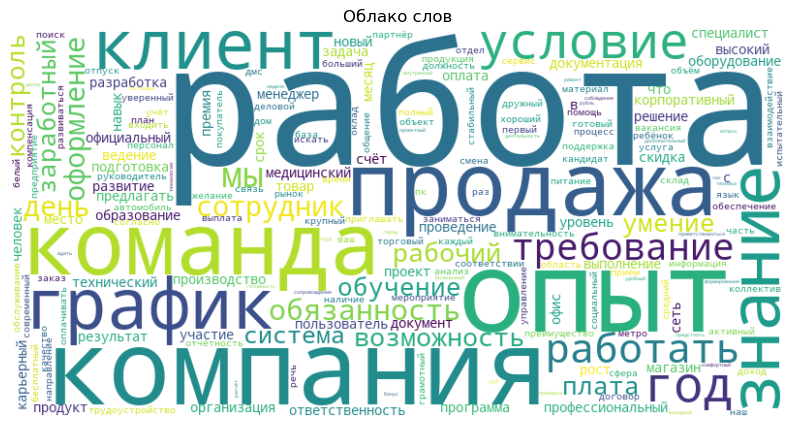

In [18]:
# визуализация облака частотности слов 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_counter)

# Отображаем облако слов
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключаем оси координат
plt.title('Облако слов')
plt.show()


In [20]:
total_data = [processor.remove_most_counter_words(most_counter_words, i) for i in total_data]
total_data = [[item.strip() for item in sublist if item.strip()] for sublist in total_data]

In [23]:
def calculate_metrics(predicted, actual):
    predicted = set(predicted)
    actual = set(actual)
    
    tp = len(predicted & actual)
    fp = len(predicted - actual)
    fn = len(actual - predicted)
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
    return precision, recall, f1_score

def compute_test(name, vectorizer, results, data, debug=False):
    print(name)
    start = time.time()
    data_resume = data.drop_duplicates(['id_cv', 'resume_description_token'])
    
    test_vacancy_desc = [ast.literal_eval(x) for x in data['vacancy_description_token'].tolist()]
    test_resume_desc = [ast.literal_eval(x) for x in data_resume['resume_description_token'].tolist()] 
    
    test_vacancy_desc = [[item.strip() for item in sublist if item.strip()] for sublist in test_vacancy_desc]
    test_resume_desc = [[item.strip() for item in sublist if item.strip()] for sublist in test_resume_desc]
    

    test_vacancy_desc = processor.remove_most_counter_words(test_vacancy_desc)
    test_resume_desc = processor.remove_most_counter_words(test_resume_desc)
         
    resume_vecs = vectorizer.vectorize(test_resume_desc)
    vacancy_vecs = vectorizer.vectorize(test_vacancy_desc)
    
    # Вычисление косинусного сходства и предсказание
    cos_sim = cosine_similarity(resume_vecs, vacancy_vecs)      
    
    top_10_preds = np.argsort(-cos_sim, axis=1)[:, :10]    
    
    end_time =  time.time() - start
    
    assert(len(cos_sim) == len(set(data_resume['id_cv'])), f'cos_sim {len(cos_sim)} id_cv {0}')
    
    # Сохраняем результаты
    precision_scores, recall_scores, f1_scores = [], [], []
    
    for idx, row in enumerate(data_resume['id_cv']):   
        
        actual_ids = data[data['id_cv'] == row]['id_vacancy'].tolist()
        
        print('фактические id вакансий для резюме')
        print(actual_ids)
        
        if debug:
            print('токены резюме')
            print(data[data['id_cv'] == row].resume_description.iloc[0])
        
        predicted_indices = top_10_preds[idx]    
        # конвертируем предсказанные индексы вакансий в фактические идентификаторы
        predicted_ids = [data.iloc[i]['id_vacancy'] for i in predicted_indices]
        
        print('предсказанные индексы вакансий')
        print(predicted_ids)
        
        if debug:
            print('предсказанные токены описаний вакансий')
            for id_ in predicted_ids:
                print(data[data['id_vacancy'] == id_].vacancy_description.iloc[0])
        
        prec, rec, f1 = calculate_metrics(predicted_ids, actual_ids)
        
        precision_scores.append(prec)
        recall_scores.append(rec)
        f1_scores.append(f1)            
        
    results[name] = {
        'F1 Score': np.mean(f1_scores),
        'Time': end_time,
        'Mean Cosine Similarity': np.mean(cos_sim),
        'Top 10 Mean Cosine Similarity': np.mean(np.sort(cos_sim, axis=1)[:, -10:]),
    }


<>:40: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:40: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_12284\4110467057.py:40: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(cos_sim) == len(set(data_resume['id_cv'])), f'cos_sim {len(cos_sim)} id_cv {0}')


In [7]:
fasttext_vectorizer = FastTextVectorizer(processor)
tfidf_vectorizer = TFIDFVectorizer(processor)
word2vec_vectorizer = Word2VecVectorizer(processor)
# bert_vectorizer = BERTVectorizer()
   

In [ ]:
%%time
learning_time_tfidf = tfidf_vectorizer.fit(total_data)

In [ ]:
%%time
learning_time_fasttext = fasttext_vectorizer.fit(total_data)

In [ ]:
%%time
learning_time_word2vec = word2vec_vectorizer.fit(total_data)

In [25]:
# # Создаем словарь для результатов
results = {}

vectorizers = {
    'tfidf': tfidf_vectorizer,
    'fastText': fasttext_vectorizer,
    'word2vec': word2vec_vectorizer
}

for name, vectorizer in vectorizers.items():
    compute_test(name, vectorizer, results, test_data[:100], debug=True)

# Вывод результатов
for method, metrics in results.items():
    print(f"Results for {method}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

tfidf
------------------------------
фактические id вакансий для резюме
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
токены резюме
Водитель погрузчика    2007-11-01    2008-10-01    ООО"ГАЛОПОЛИМЕР"    Отгрузка готовой продукции на склад хранения Водитель погрузчика    2018-06-01        ООО"Пивоварня Эфест"    Работа на складе Водитель погрузчика    2018-06-01    2018-09-01    ООО"Пивоварня Эфест"    Работа на складе Водитель погрузчика    2018-09-01    2018-12-01    АО"Колымская россыпь"    Погрузка горных масс Аппаратчик, водитель погрузчика    2017-10-01    2018-06-01    Агрохимикат    Подвоз компонентов на поддонах и в кубах в цех смешивания
предсказанные индексы вакансий
[5, 1, 2, 10, 4, 7, 8, 9, 3, 6]
предсказанные токены описаний вакансий
Водитель погрузчика    машинист вилочного погрузчика, автогидроподъемника осуществляет управление погрузчиком, для выполнения погрузки и разгрузки    образование Среднее        Полная занятость
водитель погрузчика    производить погрузку на объекте         

------------------------------
фактические id вакансий для резюме
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
токены резюме
Водитель погрузчика    2007-11-01    2008-10-01    ООО"ГАЛОПОЛИМЕР"    Отгрузка готовой продукции на склад хранения Водитель погрузчика    2018-06-01        ООО"Пивоварня Эфест"    Работа на складе Водитель погрузчика    2018-06-01    2018-09-01    ООО"Пивоварня Эфест"    Работа на складе Водитель погрузчика    2018-09-01    2018-12-01    АО"Колымская россыпь"    Погрузка горных масс Аппаратчик, водитель погрузчика    2017-10-01    2018-06-01    Агрохимикат    Подвоз компонентов на поддонах и в кубах в цех смешивания
предсказанные индексы вакансий
[5, 8, 1, 2, 4, 10, 7, 9, 62, 66]
предсказанные токены описаний вакансий
Водитель погрузчика    машинист вилочного погрузчика, автогидроподъемника осуществляет управление погрузчиком, для выполнения погрузки и разгрузки    образование Среднее        Полная занятость
Водитель вилочного погрузчика    Погрузка и разгрузка комплектующих

------------------------------
фактические id вакансий для резюме
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
токены резюме
Водитель погрузчика    2007-11-01    2008-10-01    ООО"ГАЛОПОЛИМЕР"    Отгрузка готовой продукции на склад хранения Водитель погрузчика    2018-06-01        ООО"Пивоварня Эфест"    Работа на складе Водитель погрузчика    2018-06-01    2018-09-01    ООО"Пивоварня Эфест"    Работа на складе Водитель погрузчика    2018-09-01    2018-12-01    АО"Колымская россыпь"    Погрузка горных масс Аппаратчик, водитель погрузчика    2017-10-01    2018-06-01    Агрохимикат    Подвоз компонентов на поддонах и в кубах в цех смешивания
предсказанные индексы вакансий
[5, 8, 1, 2, 10, 4, 9, 7, 66, 25]
предсказанные токены описаний вакансий
Водитель погрузчика    машинист вилочного погрузчика, автогидроподъемника осуществляет управление погрузчиком, для выполнения погрузки и разгрузки    образование Среднее        Полная занятость
Водитель вилочного погрузчика    Погрузка и разгрузка комплектующих

In [18]:
# Вывод результатов
for method, metrics in results.items():
    print(f"Results for {method}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

Results for tfidf:
F1 Score: 0.46
Time: 0.67
Mean Cosine Similarity: 0.01
Top 10 Mean Cosine Similarity: 0.27
Results for fastText:
F1 Score: 0.15
Time: 1.70
Mean Cosine Similarity: 0.60
Top 10 Mean Cosine Similarity: 0.86
Results for word2vec:
F1 Score: 0.15
Time: 1.01
Mean Cosine Similarity: 0.31
Top 10 Mean Cosine Similarity: 0.76


Сохраняем модели для использования в fastApi

In [ ]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib', protocol=4)

In [ ]:
fasttext_vectorizer.model.save('fasttext_model')

In [ ]:
word2vec_vectorizer.model.save('word2vec_model')

# Векторизуем описания вакаснсий с помощью обученных моделей и сохраняем в БД vacancies

In [31]:
from gensim.models import Word2Vec, FastText
from scipy.sparse import save_npz, load_npz

In [60]:
train_data.head(1)

,id,name,professional_role_id,description_all,vacancy_description_proc,vacancy_description_toc,fasttext_v,word2vec_v
0,18330133,Агент по недвижимости (м. Пролетарская),1,Агент по недвижимости (м. Пролетарская) Компан...,недвижимость лет успешно работает рынке мы при...,"недвижимость,год,успешно,работать,рынок,мы,при...","[-3.0838541984558105, -1.3007066249847412, 1.1...","[-37.74424743652344, -72.20755004882812, 51.80..."


In [8]:
tfidf_vectorizer = joblib.load(r'tfidf_vectorizer.joblib')
word2vec_model = Word2Vec.load('word2vec_model')
fasttext_model = FastText.load('fasttext_model')

In [9]:
fasttext_vectorizer.model = fasttext_model
word2vec_vectorizer.model = word2vec_model

In [ ]:
train_data_list = train_data['vacancy_description_toc'].str.split(',').tolist()
train_data_list = [[item.strip() for item in sublist if item.strip()] for sublist in train_data_list]
train_data_list = [processor.remove_most_counter_words(most_counter_words, i) for i in train_data_list]

assert(len(train_data_list) == train_data.shape[0])

In [65]:
vectors = tfidf_vectorizer.vectorize(train_data_list)
save_npz('tfidf_vectors.npz', vectors)

In [ ]:
vectors = fasttext_vectorizer.vectorize(train_data_list)
train_data['fasttext_v'] = vectors.tolist()

In [89]:
vectors = word2vec_vectorizer.vectorize(train_data_list)
train_data['word2vec_v'] = vectors.tolist()

In [96]:
train_data['fasttext_v'] = train_data['fasttext_v'].apply(lambda x: ','.join(map(str, x)))

In [97]:
train_data['word2vec_v'] = train_data['word2vec_v'].apply(lambda x: ','.join(map(str, x)))

In [98]:
train_data.head(2)

,id,name,professional_role_id,description_all,vacancy_description_proc,vacancy_description_toc,fasttext_v,word2vec_v
0,18330133,Агент по недвижимости (м. Пролетарская),1,Агент по недвижимости (м. Пролетарская) Компан...,недвижимость лет успешно работает рынке мы при...,"недвижимость,год,успешно,работать,рынок,мы,при...","-3.0838541984558105,-1.3007066249847412,1.1349...","-37.74424743652344,-72.20755004882812,51.80692..."
1,20155035,Руководитель отдела продаж (Private Banking),2,Руководитель отдела продаж (Private Banking) А...,руководитель отдела продаж private banking ато...,"руководитель,отдел,продажа,private,banking,ато...","-2.897848606109619,-2.09171986579895,0.6688437...","-48.28194808959961,-99.79778289794922,133.8851..."


In [ ]:
sqlite3_adapter.write(train_data)

# Инференс

In [ ]:
fasttext_vectorizer = FastTextVectorizer(processor)
word2vec_vectorizer = Word2VecVectorizer(processor)

tfidf_vectorizer = joblib.load(r'tfidf_vectorizer.joblib')
word2vec_model = Word2Vec.load('word2vec_model')
fasttext_model = FastText.load('fasttext_model')
fasttext_vectorizer.model = fasttext_model
word2vec_vectorizer.model = word2vec_model

In [ ]:
sqlite3_adapter = SqlLitePdAdapter('', 'vacancies', 'vacancies')

train_data = pd.DataFrame()
chunk_size = 10000  

for chunk in sqlite3_adapter.read_all(chunksize=chunk_size):
    train_data = pd.concat([train_data, chunk], ignore_index=True)

In [19]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
fast_text_vectors_array = train_data['fasttext_v'].parallel_apply(lambda x: x.split(',')).to_numpy()

In [17]:
wor2vec_vectors_array = train_data['word2vec_v'].parallel_apply(lambda x: x.split(',')).to_numpy()

In [18]:
type(fast_text_vectors_array[0])

list

In [33]:
tfidf_vectors = load_npz('tfidf_vectors.npz')

In [19]:
test_resume = 'Опытный разработчик Python с более чем 5 годами опыта в разработке программного обеспечения. Глубокие знания Python и его фреймворков, таких как Django и Flask. Опыт работы с базами данных, такими как PostgreSQL и MongoDB. Занимался разработкой веб-приложений, автоматизацией задач, разработкой API и интеграцией сторонних сервисов.  Опыт работы:  Разработчик Python в ООО "ТехноКод" (2018 - настоящее время) Разработка и поддержка веб-приложений на основе Django. Интеграция с внешними API для обмена данными. Разработка и оптимизация баз данных PostgreSQL. Junior разработчик Python в ООО "Развитие Технологий" (2016 - 2018) Разработка и тестирование функционала веб-приложений. Участие в разработке API для внутренних сервисов. Поддержка и оптимизация существующего кода. Образование:  Бакалавр информационных технологий, Университет ИТМО (2016) Навыки:  Языки программирования: Python, SQL Фреймворки: Django, Flask Базы данных: PostgreSQL, MongoDB Веб-технологии: HTML, CSS, JavaScript Системы контроля версий: Git Дополнительная информация:  Участник митапов по Python и веб-разработке. Сертификат по курсу "Основы разработки на Python" от Coursera. Активный участник open-source проектов.'

In [25]:
text = processor.preprocess_text(test_resume)
text_toc = processor.spacy_tokenize(text)
text_toc = processor.remove_most_counter_words(text_toc)

In [37]:
resume_vecs = word2vec_vectorizer.vectorize(text_toc)
vacancy_vecs = np.vstack(wor2vec_vectors_array)

In [38]:
cos_sim = cosine_similarity(resume_vecs, vacancy_vecs)     
    
top_10_preds = np.argsort(-cos_sim, axis=1)[:, :10] 

In [ ]:
for ind in top_10_preds[0]:
    vacancy = train_data.iloc[ind]
    id = vacancy['id'].iloc[0]
    title = vacancy['name'].iloc[0]
    description = vacancy['description_all'].iloc[0]
    
    print(description)